In [31]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report

In [32]:
model = vgg16(pretrained=True, progress=False)

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for param in model.parameters():
    param.requires_grad = False

model.classifier[6] = torch.nn.Linear(4096, 3)
model = model.to(device)

In [34]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(64),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]
)

In [35]:
train_dataset = ImageFolder(root='data/train', transform=my_transform_train)
test_dataset = ImageFolder(root='data/val', transform=my_transform_test)

In [36]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [37]:
num_epochs = 6
lr = 1e-4
optimizer = Adam(model.parameters(), lr=lr)

In [38]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

loss train 0.5710599464282654
loss test 0.16379878520965574


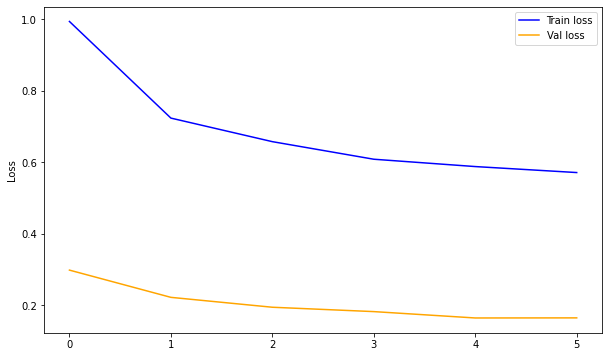

In [39]:
all_train_losses = []
all_test_losses = []
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.train(False)
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()

In [40]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [41]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [42]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [43]:
real

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [44]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       500
           1       0.93      0.96      0.95       500
           2       0.96      0.89      0.92       500

    accuracy                           0.94      1500
   macro avg       0.94      0.94      0.94      1500
weighted avg       0.94      0.94      0.94      1500



In [45]:
torch.save(model.state_dict(), 'model.pth')